In [17]:
# Install dependencies
# DON'T RUN
# !pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1

# Inline plots
%matplotlib inline

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
from numerapi import NumerAPI
napi = NumerAPI()

import pandas as pd

# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))

# Set data version to one of the latest datasets
DATA_VERSION = "v4.3"

In [20]:
import json

# # download the feature metadata file
# napi.download_dataset(f"{DATA_VERSION}/features.json"); # ONLY RUN ONCE!

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]

small_feature_set = feature_sets["small"]
medium_feature_set = feature_sets["medium"]

# # Download the training data - this will take a few minutes
# napi.download_dataset(f"{DATA_VERSION}/train_int8.parquet"); # ONLY RUN ONCE!

# Load only the "small" and "medium" feature set to
# Use the "all" feature set to use all features
small_data = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + small_feature_set
)
medium_data = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + medium_feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
small_data = small_data[small_data["era"].isin(small_data["era"].unique()[::4])]
medium_data = medium_data[medium_data["era"].isin(medium_data["era"].unique()[::4])]


In [21]:
small_X_train = small_data[small_feature_set]
small_y_train = small_data["target"]
medium_X_train = medium_data[medium_feature_set]
medium_y_train = medium_data["target"]

In [22]:
# # For Binary classifiation
# test = test.apply(lambda x: 1 if x>0.5 else 0 )
# test = pd.Categorical(test).codes

In [23]:
# find correlation between features and outcome
corr = medium_X_train.corrwith(medium_y_train)
corr.sort_values()

feature_enzymatic_poorest_advocaat             -0.011773
feature_unswaddled_inenarrable_goody           -0.011449
feature_wetter_unbaffled_loma                  -0.007477
feature_floatiest_quintuplicate_carpentering   -0.007150
feature_unbarking_apolitical_hibernian         -0.007114
                                                  ...   
feature_hunchbacked_unturning_meditation        0.010299
feature_denuded_typed_wattmeter                 0.010343
feature_pruinose_raploch_roubaix                0.010585
feature_leaky_overloaded_rhodium                0.011407
feature_simpatico_cadential_pup                 0.012055
Length: 705, dtype: float64

In [58]:
# Find the most correlated features
corr_sorted = abs(corr).sort_values(ascending=False)
corr_sorted

feature_simpatico_cadential_pup                    0.012055
feature_enzymatic_poorest_advocaat                 0.011773
feature_unswaddled_inenarrable_goody               0.011449
feature_leaky_overloaded_rhodium                   0.011407
feature_pruinose_raploch_roubaix                   0.010585
                                                     ...   
feature_uneasy_unaccommodating_immortality         0.000033
feature_coordinate_shyer_evildoing                 0.000029
feature_refractory_topped_dependance               0.000027
feature_hagiographical_fertile_disestablishment    0.000016
feature_accommodable_crinite_cleft                 0.000007
Length: 705, dtype: float64

In [25]:
# # get 100 most correlated features
# medium100_feature_set = corr.columns # can't get it to work
# medium100_X_train = medium_X_train[medium100_feature_set]

In [26]:
small_y_train = pd.Categorical(small_y_train).codes
medium_y_train = pd.Categorical(medium_y_train).codes

In [27]:
# Parameters to grid search
feature_set_sizes = {'small': [small_X_train,small_y_train], 'medium': [medium_X_train,medium_y_train]}
# lambds = [1.0, 0.1, 0.01, 0.001, 0.0001] # I dont think necessary
regularizations = ['l1', 'l2', 'l1l2']
activations = ['relu', 'sigmoid']
learning_rates = [1.0, 0.1, 0.01, 0.001, 0.0001]

models = {}

In [28]:
import sklearn as sk
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu, linear, sigmoid, softmax
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from keras.optimizers import Adam

In [29]:
for reg in regularizations:
  for activation in activations:
    for alpha in learning_rates:
      model_S30_15_5 = Sequential(
          [
              tf.keras.Input(shape=(small_X_train.shape[1],)),    #specify input size
              Dense(units=30, activation=activation, kernel_regularizer=reg),
              Dense(units=15, activation=activation, kernel_regularizer=reg),
              Dense(units=5, activation='linear', kernel_regularizer=reg)

          ], name = "model_S30_15_5" +'_' + activation +'_'+ reg+'_'+ str(alpha)
      )
      models[model_S30_15_5.name] = model_S30_15_5

      model_S25_5 = Sequential(
          [
              tf.keras.Input(shape=(small_X_train.shape[1],)),    #specify input size
              Dense(units=25, activation=activation, kernel_regularizer=reg),
              Dense(units=5, activation='linear', kernel_regularizer=reg)

          ], name = "model_S25_5" +'_'+ activation +'_'+ reg+'_'+ str(alpha)
      )
      models[model_S25_5.name] = model_S25_5

      model_M300_100_50_25_5 = Sequential(
          [
              tf.keras.Input(shape=(medium_X_train.shape[1],)),    #specify input size
              Dense(units=300, activation=activation, kernel_regularizer=reg),
              Dense(units=100, activation=activation, kernel_regularizer=reg),
              Dense(units=50, activation=activation, kernel_regularizer=reg),
              Dense(units=25, activation=activation, kernel_regularizer=reg),
              Dense(units=5, activation='linear', kernel_regularizer=reg)

          ], name = "model_M300_100_50_25_5"+'_' + activation +'_'+ reg+'_'+ str(alpha)
      )
      models[model_M300_100_50_25_5.name] = model_M300_100_50_25_5

      model_M100_50_25_5 = Sequential(
          [
              tf.keras.Input(shape=(medium_X_train.shape[1],)),    #specify input size
              Dense(units=100, activation=activation, kernel_regularizer=reg),
              Dense(units=50, activation=activation, kernel_regularizer=reg),
              Dense(units=25, activation=activation, kernel_regularizer=reg),
              Dense(units=5, activation='linear', kernel_regularizer=reg)

          ], name = "model_M100_50_25_5"+'_' + activation +'_'+ reg+'_'+ str(alpha)
      )
      models[model_M100_50_25_5.name] = model_M100_50_25_5

      model_M100_25_5 = Sequential(
          [
              tf.keras.Input(shape=(medium_X_train.shape[1],)),    #specify input size
              Dense(units=100, activation=activation, kernel_regularizer=reg),
              Dense(units=25, activation=activation, kernel_regularizer=reg),
              Dense(units=5, activation='linear', kernel_regularizer=reg)

          ], name = "model_M100_25_5"+'_' + activation +'_'+ reg+'_'+ str(alpha)
      )
      models[model_M100_25_5.name] = model_M100_25_5

In [30]:
for name, model in models.items():
  alpha = name.split('_')[-1]
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(float(alpha)),
  )

In [31]:
# for name, model in models.items():
#   print(name.split('_')[1][0])
#   print(name)
#   print(model)

# print(models.items())

In [32]:
for name, model in models.items():
  try:
    if name.split('_')[1][0] =='S':
      model.fit(
          small_X_train[:1000],small_y_train[:1000],
          epochs=2
      )
    else:
      model.fit(
          medium_X_train[:1000],medium_y_train[:1000],
          epochs=2
      )

  except TypeError: # At the end running this cell a Type error happens but idk why and it doesn't effect my models so...
    pass

Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 337.4862
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.6893 
Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 203.9519 
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47.3199 
Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7918924.0000 
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16855.1289
Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 279757.2188
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2968.7517 
Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 45508.5664
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2481.5986 
Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.5311   
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6510 
Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5431  
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2363
Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 644.

In [33]:
predictions = {}
for name, model in models.items():
  if name.split('_')[1][0] =='S':
    prediction = model.predict(small_X_train[:1000])

  else:
    prediction = model.predict(medium_X_train[:1000])

  hard_prediction = np.array([np.argmax(prediction[i]) for i in range(len(prediction))])

  # # For binary classification
# hard_prediction = np.array([1 if prediction[i]>0.5 else 0 for i in range(len(prediction))])

  predictions[name] = hard_prediction

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━

In [34]:
# for name, prediction in predictions.items():
#   print (name+ ': ', prediction)
#   print(small_y_train[:1000])

In [35]:
train_accuracies = {}
best_models = []
for name, prediction in predictions.items():
  if name.split('_')[1][0] =='S':
    # compute_metrics(
    # small_X_train, small_y_train, prediction, sample_weight=None
    # )
    accuracy = (small_y_train[:1000] == prediction).sum() / len(small_y_train[:1000])

  else:
    # compute_metrics(
    # small_X_train, small_y_train, prediction, sample_weight=None
    # )
    accuracy = (medium_y_train[:1000] == prediction).sum() / len(medium_y_train[:1000])

  if accuracy>=0.5:
    best_models.append(name)
    print(name, accuracy)
  train_accuracies[name] = accuracy
  # print(name, accuracy)

model_S30_15_5_relu_l1_0.001 0.503
model_M100_25_5_relu_l1_0.001 0.5
model_M100_50_25_5_relu_l1l2_0.0001 0.502


In [36]:
best_models

['model_S30_15_5_relu_l1_0.001',
 'model_M100_25_5_relu_l1_0.001',
 'model_M100_50_25_5_relu_l1l2_0.0001']

In [37]:
# Download validation data - this will take a few minutes
# napi.download_dataset(f"{DATA_VERSION}/validation_int8.parquet"); # ONLY RUN ONCE!

# Load the validation data and filter for data_type == "validation"
small_validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + small_feature_set
)
medium_validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + medium_feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
small_validation = small_validation[small_validation["era"].isin(small_validation["era"].unique()[::4])]
medium_validation = medium_validation[medium_validation["era"].isin(medium_validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(small_data["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
small_validation = small_validation[~small_validation["era"].isin(eras_to_embargo)]
medium_validation = medium_validation[~medium_validation["era"].isin(eras_to_embargo)]

# # Generate predictions against the out-of-sample validation features
# # This will take a few minutes 🍵
# small_validation["prediction"] = model.predict(small_validation[small_feature_set])
# medium_validation["prediction"] = model.predict(medium_validation[medium_feature_set])
# small_validation[["era", "prediction", "target"]]
# medium_validation[["era", "prediction", "target"]]

In [38]:
small_X_val = small_validation[small_feature_set]
small_y_val = small_validation['target']
medium_X_val = medium_validation[medium_feature_set]
medium_y_val = medium_validation['target']

small_y_val = pd.Categorical(small_y_val).codes
medium_y_val = pd.Categorical(medium_y_val).codes

In [39]:
val_predictions = {}
# predict for best small models
for name in best_models:
  model = models[name]
  if name.split('_')[1][0] =='S':
    prediction = model.predict(small_X_val[:1000])

  else:
    prediction = model.predict(medium_X_val[:1000])

  hard_prediction = np.array([np.argmax(prediction[i]) for i in range(len(prediction))])

  # # For binary classification
  # hard_prediction = np.array([1 if prediction[i]>0.5 else 0 for i in range(len(prediction))])

  val_predictions[name] = hard_prediction


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [40]:
val_accuracies = {}
# predict for medium models
for name, prediction in val_predictions.items():
  if name.split('_')[1][0] =='S':
    # compute_metrics(
    # small_X_train, small_y_train, prediction, sample_weight=None
    # )
    accuracy = (small_y_val[:1000] == prediction).sum() / len(small_y_val[:1000])

  else:
    # compute_metrics(
    # small_X_train, small_y_train, prediction, sample_weight=None
    # )
    accuracy = (medium_y_val[:1000] == prediction).sum() / len(medium_y_val[:1000])


  val_accuracies[name] = accuracy
  print(name, accuracy)


model_S30_15_5_relu_l1_0.001 0.492
model_M100_25_5_relu_l1_0.001 0.423
model_M100_50_25_5_relu_l1l2_0.0001 0.497


In [42]:
best_m_name = 'model_M100_50_25_5_relu_l1l2_0.0001'

In [44]:
# Now train best model using all of the data
best_model = models[best_m_name]

best_model.fit(
    medium_X_train,medium_y_train,
          epochs=2)


Epoch 1/2
18943/18943 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 1.2618
Epoch 2/2
18943/18943 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 1.2455


In [47]:
best_prediction = best_model.predict(medium_X_val)

hard_prediction = np.array([np.argmax(best_prediction[i]) for i in range(len(best_prediction))])
best_prediction = hard_prediction

accuracy = (medium_y_val == best_prediction).sum() / len(medium_y_val)


21299/21299 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step


In [48]:
print("Best Model accuracy: ", accuracy)


Best Model accuracy:  0.4962563000242097


Below are some helpful visualizations

In [ ]:
# Plot accuracy for each model on the training and validation set (X-axis: model, y-axis: accuracy score)

Text(0, 0.5, 'Training Accuracy')

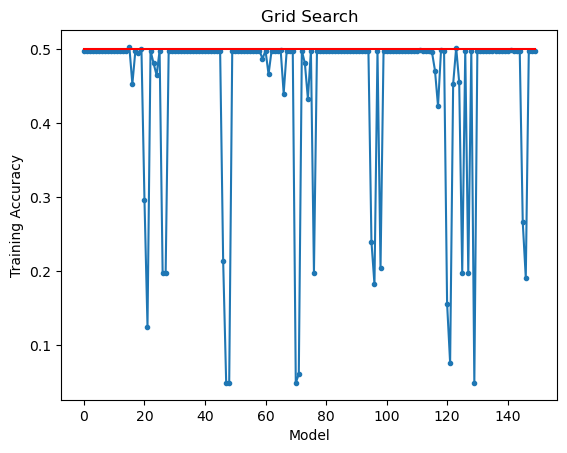

In [56]:
# training error
plt.plot(range(len(train_accuracies.keys())),train_accuracies.values(),marker='.')
plt.plot(range(len(train_accuracies.keys())), np.repeat(0.5, len(train_accuracies.keys())), color='r')
plt.title('Grid Search')
plt.xlabel('Model')
plt.ylabel('Training Accuracy')

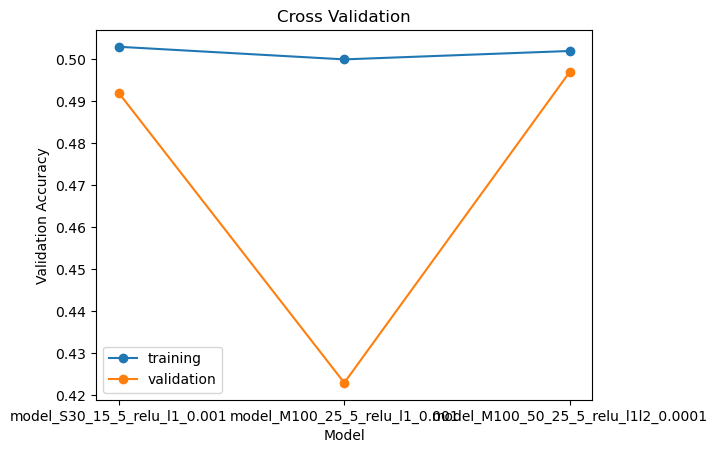

In [59]:
# val error
best_train_scores = [0.503,0.5,0.502]
plt.plot(range(len(best_train_scores)),best_train_scores,marker='o', label='training')
plt.plot(val_accuracies.keys(),val_accuracies.values(),marker='o', label='validation')
plt.title('Cross Validation')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.legend()